# Frequency correlation plots for simulated populations

Another attempt at calculating clade frequencies from tip-to-clade mappings without using a full tree.

In [307]:
import altair as alt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns

%matplotlib inline

In [309]:
sns.set_style("white")
plt.style.use("huddlej")

In [310]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 18

In [4]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [257]:
def matthews_correlation_coefficient(tp, tn, fp, fn):
    """Return Matthews correlation coefficient for values from a confusion matrix.
    Implementation is based on the definition from wikipedia:

    https://en.wikipedia.org/wiki/Matthews_correlation_coefficient
    """
    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    if denominator == 0:
            denominator = 1

    return float(numerator) / denominator

def get_matthews_correlation_coefficient_for_data_frame(freq_df, return_confusion_matrix=False):
        """Calculate Matthew's correlation coefficient from a given pandas data frame
        with columns for initial, observed, and predicted frequencies.
        """
        observed_growth = (freq_df["observed_frequency"] > freq_df["initial_frequency"])
        predicted_growth = (freq_df["estimated_frequency"] > freq_df["initial_frequency"])
        true_positives = ((observed_growth) & (predicted_growth)).sum()
        false_positives= ((~observed_growth) & (predicted_growth)).sum()

        observed_decline = (freq_df["observed_frequency"] <= freq_df["initial_frequency"])
        predicted_decline = (freq_df["estimated_frequency"] <= freq_df["initial_frequency"])
        true_negatives = ((observed_decline) & (predicted_decline)).sum()
        false_negatives = ((~observed_decline) & (predicted_decline)).sum()

        mcc = matthews_correlation_coefficient(
            true_positives,
            true_negatives,
            false_positives,
            false_negatives
        )

        if return_confusion_matrix:
            confusion_matrix = {
                "tp": true_positives,
                "tn": true_negatives,
                "fp": false_positives,
                "fn": false_negatives
            }
            
            return mcc, confusion_matrix
        else:
            return mcc

## Load data

In [484]:
data_root = "../results/builds/simulated/simulated_sample_1/"

In [485]:
tips = pd.read_csv(
    "%s/tip_attributes_with_weighted_distances.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["strain", "timepoint", "frequency"]
)

In [486]:
first_validation_timepoint = "2023-10-01"

In [487]:
tips = tips.query("timepoint >= '%s'" % first_validation_timepoint).copy()

In [488]:
tips.shape

(2875, 3)

In [489]:
tips["future_timepoint"] = tips["timepoint"] + pd.DateOffset(months=12)

In [490]:
tips.set_index(["timepoint", "future_timepoint", "strain"], inplace=True)

In [491]:
tips.head(1)

,,,frequency
timepoint,future_timepoint,strain,
2023-10-01,2024-10-01,sample_4616_1,0.000012


In [492]:
tips_to_clades = pd.read_csv("%s/tips_to_clades.tsv" % data_root, sep="\t", parse_dates=["timepoint"])

In [493]:
tips_to_clades = tips_to_clades.query("timepoint >= '%s'" % first_validation_timepoint).copy()

In [494]:
tips_to_clades = tips_to_clades.rename(columns={"tip": "strain"})

In [495]:
tips_to_clades.set_index(["timepoint", "strain"], inplace=True)

In [496]:
tips_to_clades.head()

clade_membership  depth
timepoint  strain                               
2023-10-01 sample_3600_1          81fd9c8      0
           sample_3560_5          81fd9c8      0
           sample_3584_6          81fd9c8      0
           sample_3560_4          c67ab0a      0
           sample_3560_4          1aa93ba      2

In [497]:
tips_to_clades.shape

(288819, 2)

In [498]:
forecasts = pd.read_csv(
    "%s/forecasts.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["timepoint", "strain", "projected_frequency"]
)

In [499]:
forecasts.set_index(["timepoint", "strain"], inplace=True)

In [500]:
forecasts.head()

projected_frequency
timepoint  strain                             
2016-10-01 sample_3216_5          1.284285e-08
           sample_3216_7          1.295382e-07
           sample_3220_3          4.939963e-07
           sample_3224_1          6.454219e-07
           sample_3224_10         4.716771e-08

In [501]:
full_forecasts = pd.read_csv(
    "%s/forecasts.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint", "future_timepoint"]
)

In [502]:
full_forecasts = full_forecasts.query("timepoint >= '%s'" % first_validation_timepoint).copy()

## Find clades for tips at future timepoint

Annotate projected frequencies for each tip by timepoint.

In [505]:
tips = tips.join(forecasts, on=["timepoint", "strain"])

In [532]:
tips_with_current_clades = tips.join(
    tips_to_clades,
    on=["timepoint", "strain"]
).reset_index().rename(columns={
    "level_0": "timepoint",
    "level_2": "strain"
})

In [533]:
tips_with_current_clades.shape

(54624, 7)

In [535]:
tips_with_current_clades.head()

,timepoint,future_timepoint,strain,frequency,projected_frequency,clade_membership,depth
0,2023-10-01,2024-10-01,sample_4616_1,0.000012,0.000049,4142c6d,0
1,2023-10-01,2024-10-01,sample_4616_1,0.000012,0.000049,2ec232d,4
2,2023-10-01,2024-10-01,sample_4616_1,0.000012,0.000049,508e469,5
3,2023-10-01,2024-10-01,sample_4616_1,0.000012,0.000049,60842de,10
4,2023-10-01,2024-10-01,sample_4616_1,0.000012,0.000049,165aaed,12


In [536]:
current_tips_with_future_clades = tips.join(
    tips_to_clades,
    on=["future_timepoint", "strain"]
).reset_index().rename(columns={
    "level_1": "future_timepoint",
    "level_2": "strain"
})

In [537]:
current_tips_with_future_clades.head()

,timepoint,future_timepoint,strain,frequency,projected_frequency,clade_membership,depth
0,2023-10-01,2024-10-01,sample_4616_1,0.000012,0.000049,4142c6d,0.0
1,2023-10-01,2024-10-01,sample_4616_1,0.000012,0.000049,2ec232d,4.0
2,2023-10-01,2024-10-01,sample_4616_1,0.000012,0.000049,508e469,5.0
3,2023-10-01,2024-10-01,sample_4616_1,0.000012,0.000049,60842de,10.0
4,2023-10-01,2024-10-01,sample_4616_1,0.000012,0.000049,165aaed,12.0


In [538]:
current_tips_with_future_clades.shape

(43905, 7)

If we take the closest clade to each tip and sum tip frequencies by timepoint, we should get 100% frequency for each timepoint.

In [539]:
current_tips_with_future_clades.groupby(["timepoint", "future_timepoint", "strain", "frequency"]).first().reset_index().groupby([
    "timepoint"
])["frequency"].sum()

timepoint
2023-10-01    0.999997
2024-04-01    0.999992
2024-10-01    0.999992
2025-04-01    0.999999
2025-10-01    0.999998
2026-04-01    0.999995
2026-10-01    0.999997
2027-04-01    0.999999
2027-10-01    0.999998
2028-04-01    1.000000
2028-10-01    1.000000
2029-04-01    0.999997
2029-10-01    0.999991
2030-04-01    0.999995
2030-10-01    1.000001
2031-04-01    0.999996
2031-10-01    0.999997
2032-04-01    0.999995
2032-10-01    0.999996
2033-04-01    1.000000
2033-10-01    0.999997
2034-04-01    0.999998
2034-10-01    0.999998
2035-04-01    0.999989
2035-10-01    0.999995
2036-04-01    0.999994
2036-10-01    0.999999
2037-04-01    0.999992
2037-10-01    0.999993
2038-04-01    0.999994
2038-10-01    0.999993
2039-04-01    0.999998
2039-10-01    0.999995
2040-04-01    0.999996
2040-10-01    0.999996
Name: frequency, dtype: float64

Find tips at future timepoint with same clades as current tips. To do this, find the join between timepoints and clades for current tips and future tips.

In [549]:
current_and_future_tips_with_clades = current_tips_with_future_clades.merge(
    tips_with_current_clades,
    left_on=["future_timepoint", "clade_membership"],
    right_on=["timepoint", "clade_membership"],
    suffixes=["_current", "_future"],
    copy=False
)

In [550]:
current_and_future_tips_with_clades.head()

,timepoint_current,future_timepoint_current,strain_current,frequency_current,projected_frequency_current,clade_membership,depth_current,timepoint_future,future_timepoint_future,strain_future,frequency_future,projected_frequency_future,depth_future
0,2023-10-01,2024-10-01,sample_4616_1,0.000012,0.000049,508e469,5.0,2024-10-01,2025-10-01,sample_4816_10,0.000012,0.000003,17
1,2023-10-01,2024-10-01,sample_4616_1,0.000012,0.000049,508e469,5.0,2024-10-01,2025-10-01,sample_4816_4,0.000012,0.000042,18
2,2023-10-01,2024-10-01,sample_4616_1,0.000012,0.000049,508e469,5.0,2024-10-01,2025-10-01,sample_4816_8,0.000012,0.000240,19
3,2023-10-01,2024-10-01,sample_4616_1,0.000012,0.000049,508e469,5.0,2024-10-01,2025-10-01,sample_4820_10,0.000019,0.000080,20
4,2023-10-01,2024-10-01,sample_4616_1,0.000012,0.000049,508e469,5.0,2024-10-01,2025-10-01,sample_4820_2,0.000019,0.000117,20


In [551]:
current_and_future_tips_with_clades.shape

(3025090, 13)

In [552]:
current_tips_with_assigned_clades = current_and_future_tips_with_clades.loc[
    :, ["strain_current", "timepoint_current", "timepoint_future", "frequency_current", "projected_frequency_current", "clade_membership", "depth_current"]
].drop_duplicates().sort_values(["timepoint_current", "timepoint_future", "strain_current", "depth_current"]).groupby([
    "timepoint_current", "timepoint_future", "strain_current"
]).first().reset_index()

In [553]:
current_tips_with_assigned_clades.head()

,timepoint_current,timepoint_future,strain_current,frequency_current,projected_frequency_current,clade_membership,depth_current
0,2023-10-01,2024-10-01,sample_4616_1,0.000012,4.929717e-05,508e469,5.0
1,2023-10-01,2024-10-01,sample_4616_5,0.000012,5.251921e-10,bf85e0f,5.0
2,2023-10-01,2024-10-01,sample_4620_10,0.000020,2.468120e-10,8771651,4.0
3,2023-10-01,2024-10-01,sample_4620_8,0.000020,3.890803e-05,e0dac53,9.0
4,2023-10-01,2024-10-01,sample_4624_1,0.000032,6.328626e-10,ed2cbab,18.0


In [554]:
current_tips_with_assigned_clades.shape

(2711, 7)

In [555]:
current_tips_with_assigned_clades[current_tips_with_assigned_clades["strain_current"] == "sample_5416_3"]

,timepoint_current,timepoint_future,strain_current,frequency_current,projected_frequency_current,clade_membership,depth_current
636,2027-04-01,2028-04-01,sample_5416_3,0.023712,0.006941,f05d275,2.0
658,2027-10-01,2028-10-01,sample_5416_3,0.000013,0.000005,f05d275,2.0


In [556]:
future_tips_with_assigned_clades = current_and_future_tips_with_clades.loc[
    :, ["strain_future", "timepoint_current", "timepoint_future", "frequency_future", "clade_membership", "depth_future"]
].drop_duplicates().sort_values(["timepoint_current", "timepoint_future", "strain_future", "depth_future"]).groupby([
    "timepoint_current", "timepoint_future", "strain_future"
]).first().reset_index()

In [558]:
future_tips_with_assigned_clades.shape

(2711, 6)

In [559]:
future_tips_with_assigned_clades.head()

,timepoint_current,timepoint_future,strain_future,frequency_future,clade_membership,depth_future
0,2023-10-01,2024-10-01,sample_4816_10,0.000012,dd0aca9,0
1,2023-10-01,2024-10-01,sample_4816_4,0.000012,9af1b79,2
2,2023-10-01,2024-10-01,sample_4816_8,0.000012,e47cbbd,5
3,2023-10-01,2024-10-01,sample_4820_10,0.000019,e47cbbd,6
4,2023-10-01,2024-10-01,sample_4820_2,0.000019,1690279,4


In [560]:
future_tips_with_assigned_clades.query("strain_future == 'sample_5416_3'")

,timepoint_current,timepoint_future,strain_future,frequency_future,clade_membership,depth_future
472,2026-04-01,2027-04-01,sample_5416_3,0.023712,10543f5,5
494,2026-10-01,2027-10-01,sample_5416_3,0.000013,f05d275,2


In [561]:
total_frequencies_for_current_tips = current_tips_with_assigned_clades.groupby(["timepoint_current"])["frequency_current"].sum().values

In [562]:
np.allclose(
    np.ones_like(total_frequencies_for_current_tips),
    total_frequencies_for_current_tips,
    1e-4
)

True

In [563]:
total_frequencies_for_future_tips = future_tips_with_assigned_clades.groupby(["timepoint_future"])["frequency_future"].sum().values

In [564]:
np.allclose(
    np.ones_like(total_frequencies_for_future_tips),
    total_frequencies_for_future_tips,
    1e-4
)

True

In [565]:
future_clades_for_current_timepoints = current_tips_with_assigned_clades.groupby([
    "timepoint_current", "timepoint_future", "clade_membership"
]).aggregate({"frequency_current": "sum", "projected_frequency_current": "sum"}).reset_index()

In [566]:
future_clades_for_current_timepoints.head()

,timepoint_current,timepoint_future,clade_membership,frequency_current,projected_frequency_current
0,2023-10-01,2024-10-01,0687bd9,0.002582,0.001733
1,2023-10-01,2024-10-01,1690279,0.007601,0.024792
2,2023-10-01,2024-10-01,30678e7,0.021222,0.002336
3,2023-10-01,2024-10-01,34866fa,0.093359,0.004604
4,2023-10-01,2024-10-01,508e469,0.016680,0.002497


In [567]:
future_clades_for_future_timepoints = future_tips_with_assigned_clades.groupby([
    "timepoint_current", "timepoint_future", "clade_membership"
])["frequency_future"].sum().reset_index()

In [568]:
future_clades_for_future_timepoints.head()

,timepoint_current,timepoint_future,clade_membership,frequency_future
0,2023-10-01,2024-10-01,1690279,0.652718
1,2023-10-01,2024-10-01,30678e7,0.021563
2,2023-10-01,2024-10-01,34866fa,0.000549
3,2023-10-01,2024-10-01,5390c43,0.013735
4,2023-10-01,2024-10-01,56c1c09,0.000249


In [569]:
np.allclose(
    np.ones_like(future_clades_for_current_timepoints.groupby("timepoint_current")["frequency_current"].sum().values),
    future_clades_for_current_timepoints.groupby("timepoint_current")["frequency_current"].sum().values,
    1e-4
)

True

Next, find future tips that belong to the same clades as the current tips or which have descended from these clades. Instead of taking every clade assigned to each tip, we want to pick the closest clade to each tip.

In [570]:
merged_clades = future_clades_for_current_timepoints.merge(
    future_clades_for_future_timepoints,
    how="outer",
    on=["timepoint_current", "timepoint_future", "clade_membership"]
).sort_values(["timepoint_current", "timepoint_future", "clade_membership"]).fillna(0.0)

In [571]:
merged_clades.head()

,timepoint_current,timepoint_future,clade_membership,frequency_current,projected_frequency_current,frequency_future
0,2023-10-01,2024-10-01,0687bd9,0.002582,0.001733,0.000000
1,2023-10-01,2024-10-01,1690279,0.007601,0.024792,0.652718
2,2023-10-01,2024-10-01,30678e7,0.021222,0.002336,0.021563
3,2023-10-01,2024-10-01,34866fa,0.093359,0.004604,0.000549
4,2023-10-01,2024-10-01,508e469,0.016680,0.002497,0.000000


In [572]:
merged_clades.groupby("timepoint_current")["frequency_current"].sum().values

array([0.999997, 0.999992, 0.999992, 0.999999, 0.999998, 0.999995,
       0.999997, 0.999999, 0.999998, 1.      , 1.      , 0.999997,
       0.999991, 0.999995, 1.000001, 0.999996, 0.999997, 0.999995,
       0.999996, 1.      , 0.999997, 0.999998, 0.999998, 0.999989,
       0.999995, 0.999994, 0.999999, 0.999992, 0.999993, 0.999994,
       0.999993, 0.999998, 0.999995])

In [573]:
merged_clades.groupby("timepoint_current")["frequency_future"].sum().values

array([0.999992, 0.999999, 0.999998, 0.999995, 0.999997, 0.999999,
       0.999998, 1.      , 1.      , 0.999997, 0.999991, 0.999995,
       1.000001, 0.999996, 0.999997, 0.999995, 0.999996, 1.      ,
       0.999997, 0.999998, 0.999998, 0.999989, 0.999995, 0.999994,
       0.999999, 0.999992, 0.999993, 0.999994, 0.999993, 0.999998,
       0.999995, 0.999996, 0.999996])

In [574]:
merged_clades = merged_clades.rename(columns={
    "frequency_current": "initial_frequency",
    "projected_frequency_current": "estimated_frequency",
    "frequency_future": "observed_frequency"
}).copy()

In [575]:
merged_clades["observed_growth_rate"] = (
    merged_clades["observed_frequency"] / merged_clades["initial_frequency"]
)

In [576]:
merged_clades["estimated_growth_rate"] = (
    merged_clades["estimated_frequency"] / merged_clades["initial_frequency"]
)

In [577]:
merged_clades.head()

,timepoint_current,timepoint_future,clade_membership,initial_frequency,estimated_frequency,observed_frequency,observed_growth_rate,estimated_growth_rate
0,2023-10-01,2024-10-01,0687bd9,0.002582,0.001733,0.000000,0.000000,0.671194
1,2023-10-01,2024-10-01,1690279,0.007601,0.024792,0.652718,85.872648,3.261712
2,2023-10-01,2024-10-01,30678e7,0.021222,0.002336,0.021563,1.016068,0.110075
3,2023-10-01,2024-10-01,34866fa,0.093359,0.004604,0.000549,0.005881,0.049319
4,2023-10-01,2024-10-01,508e469,0.016680,0.002497,0.000000,0.000000,0.149727


In [578]:
merged_clades.query("timepoint_current == '2029-10-01'")

,timepoint_current,timepoint_future,clade_membership,initial_frequency,estimated_frequency,observed_frequency,observed_growth_rate,estimated_growth_rate
164,2029-10-01,2030-10-01,0005017,0.038204,3.778206e-03,0.000524,0.013716,0.098896
165,2029-10-01,2030-10-01,0dbb0c0,0.023759,4.777152e-02,0.000000,0.000000,2.010670
166,2029-10-01,2030-10-01,2541589,0.097581,5.412047e-02,0.000000,0.000000,0.554621
167,2029-10-01,2030-10-01,25f5cf4,0.029484,1.692234e-02,0.040692,1.380138,0.573950
168,2029-10-01,2030-10-01,694e8b2,0.246660,5.592686e-01,0.958665,3.886585,2.267367
169,2029-10-01,2030-10-01,7821f47,0.001435,7.388911e-03,0.000020,0.013937,5.149067
170,2029-10-01,2030-10-01,8ab5cc0,0.026658,2.435415e-03,0.000000,0.000000,0.091358
171,2029-10-01,2030-10-01,8afc3f0,0.234759,1.090967e-01,0.000000,0.000000,0.464718
172,2029-10-01,2030-10-01,8fb6342,0.001941,2.748069e-03,0.000000,0.000000,1.415801
173,2029-10-01,2030-10-01,a920909,0.000012,1.989415e-08,0.000000,0.000000,0.001658


## Find and analyze large clades

Find all clades with an initial frequency some minimum value (e.g., >15%).

In [244]:
large_clades = merged_clades.query("initial_frequency > 0.15").copy()

In [245]:
large_clades.head()

,timepoint_current,timepoint_future,clade_membership,initial_frequency,estimated_frequency,observed_frequency,observed_growth_rate,estimated_growth_rate
21,2022-10-01,2023-10-01,e0dac53,0.210180,0.124258,0.000000,0.00000,0.591200
37,2023-04-01,2024-04-01,d96ebde,0.251733,0.493634,0.663893,2.63729,1.960942
39,2023-04-01,2024-04-01,e0dac53,0.182203,0.198369,0.000000,0.00000,1.088724
55,2023-10-01,2024-10-01,d96ebde,0.160589,0.061470,0.000000,0.00000,0.382779
65,2024-04-01,2025-04-01,34866fa,0.177908,0.020765,0.000000,0.00000,0.116717


In [246]:
large_clades.shape

(62, 8)

In [253]:
r, p = pearsonr(
    large_clades["observed_growth_rate"],
    large_clades["estimated_growth_rate"]
)

In [254]:
r

0.06692423552663038

In [255]:
p

0.6052833678833005

In [258]:
mcc, confusion_matrix = get_matthews_correlation_coefficient_for_data_frame(large_clades, True)

In [259]:
mcc

0.06122901534747143

In [260]:
growth_accuracy = confusion_matrix["tp"] / float(confusion_matrix["tp"] + confusion_matrix["fp"])
growth_accuracy

0.24

In [261]:
decline_accuracy = confusion_matrix["tn"] / float(confusion_matrix["tn"] + confusion_matrix["fn"])
decline_accuracy

0.8108108108108109

In [262]:
min_growth_rate = 0
max_growth_rate = large_clades.loc[:, ["observed_growth_rate", "estimated_growth_rate"]].max().max() + 0.2

In [263]:
pseudofrequency = 0.001

In [265]:
large_clades["log_observed_growth_rate"] = (
    np.log10((large_clades["observed_frequency"] + pseudofrequency) / (large_clades["initial_frequency"] + pseudofrequency))
)

large_clades["log_estimated_growth_rate"] = (
    np.log10((large_clades["estimated_frequency"] + pseudofrequency) / (large_clades["initial_frequency"] + pseudofrequency))
)

In [273]:
upper_limit = np.ceil(large_clades.loc[:, ["observed_growth_rate", "estimated_growth_rate"]].max().max())

log_lower_limit = large_clades.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].min().min() - 0.1
log_upper_limit = np.ceil(large_clades.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].max().max()) + 0.1

In [268]:
r, p = pearsonr(
    large_clades["log_observed_growth_rate"],
    large_clades["log_estimated_growth_rate"]
)

In [269]:
r

-0.012358833752447628

In [270]:
p

0.9240473700589205

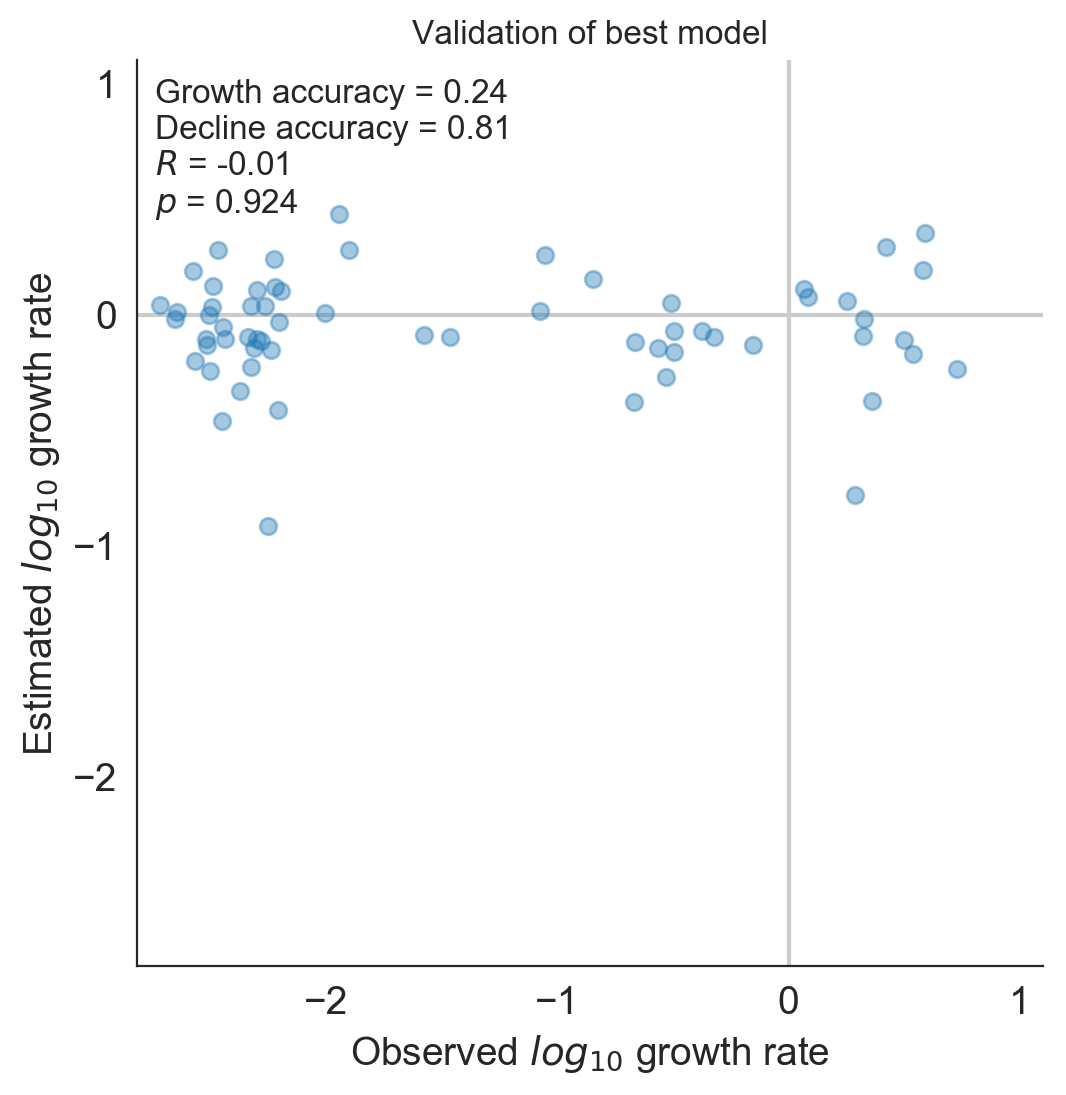

In [275]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(
    large_clades["log_observed_growth_rate"],
    large_clades["log_estimated_growth_rate"],
    "o",
    alpha=0.4
)

ax.axhline(color="#cccccc", zorder=-5)
ax.axvline(color="#cccccc", zorder=-5)

if p < 0.001:
    p_value = "$p$ < 0.001"
else:
    p_value = "$p$ = %.3f" % p

ax.text(
    0.02,
    0.9,
    "Growth accuracy = %.2f\nDecline accuracy = %.2f\n$R$ = %.2f\n%s" % (growth_accuracy, decline_accuracy, r, p_value),
    fontsize=12,
    horizontalalignment="left",
    verticalalignment="center",
    transform=ax.transAxes
)

ax.set_xlabel("Observed $log_{10}$ growth rate")
ax.set_ylabel("Estimated $log_{10}$ growth rate")
ax.set_title("Validation of best model", fontsize=12)

ticks = np.arange(-6, 4, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xlim(log_lower_limit, log_upper_limit)
ax.set_ylim(log_lower_limit, log_upper_limit)
ax.set_aspect("equal")

#plt.savefig("../manuscript/figures/validation-of-best-model-for-natural-populations.pdf")

## Estimated and observed closest strains per timepoint

Create a figure similar to Figure 2D in Neher et al. 2014 showing the minimum estimated distance to the future and minimum observed distance to the future per timepoint.

In [284]:
sorted_df = full_forecasts.dropna().sort_values(
    ["timepoint"]
).copy()

In [285]:
sorted_df["timepoint_rank"] = sorted_df.groupby("timepoint")["weighted_distance_to_future"].rank(pct=True)

In [286]:
best_fitness_rank_by_timepoint_df = sorted_df.sort_values(
    ["timepoint", "fitness"],
    ascending=False
).groupby("timepoint")["timepoint_rank"].first().reset_index()

In [292]:
best_fitness_rank_by_timepoint_df.head()

,timepoint,timepoint_rank
0,2023-10-01,0.024390
1,2024-04-01,0.804878
2,2024-10-01,0.343373
3,2025-04-01,0.120482
4,2025-10-01,0.018072


Text(0,0.5,'Number of timepoints')

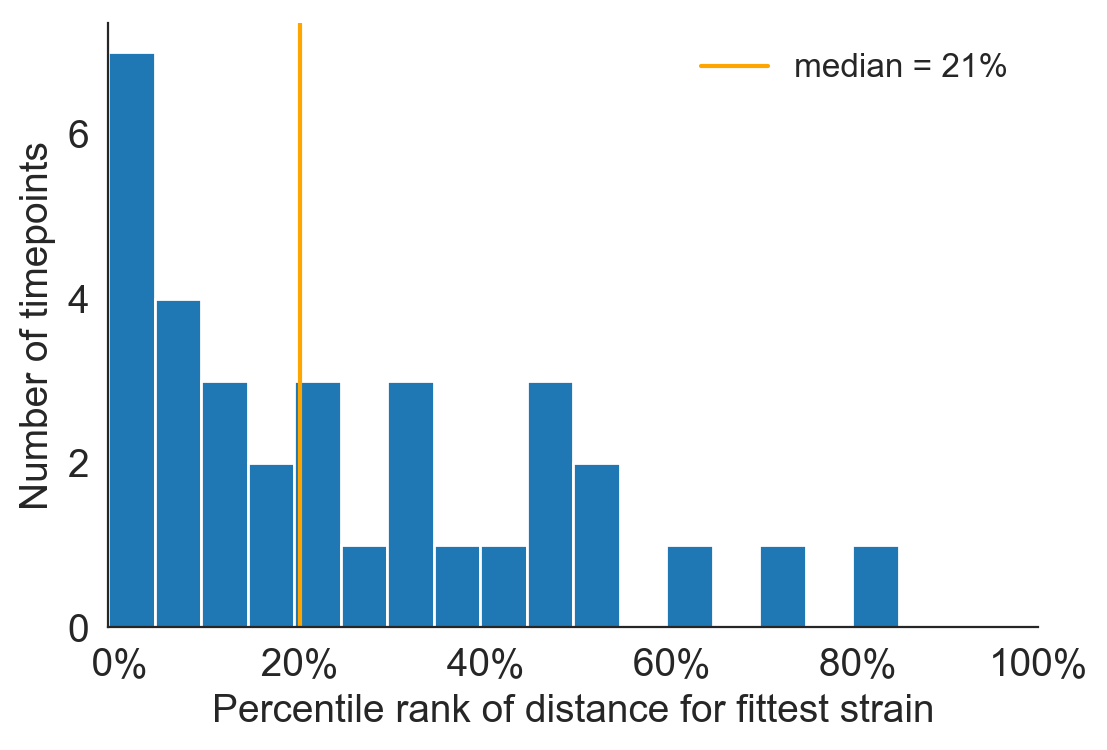

In [302]:
median_best_rank = best_fitness_rank_by_timepoint_df["timepoint_rank"].median()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(best_fitness_rank_by_timepoint_df["timepoint_rank"], bins=np.arange(0, 1.01, 0.05), label=None)
ax.axvline(
    median_best_rank,
    color="orange",
    label="median = %i%%" % round(median_best_rank * 100, 0)
)
ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
ax.set_xlim(0, 1)

ax.legend(
    frameon=False
)
ax.set_xlabel("Percentile rank of distance for fittest strain")
ax.set_ylabel("Number of timepoints")

## Merge validation figures into subpanels of one figure

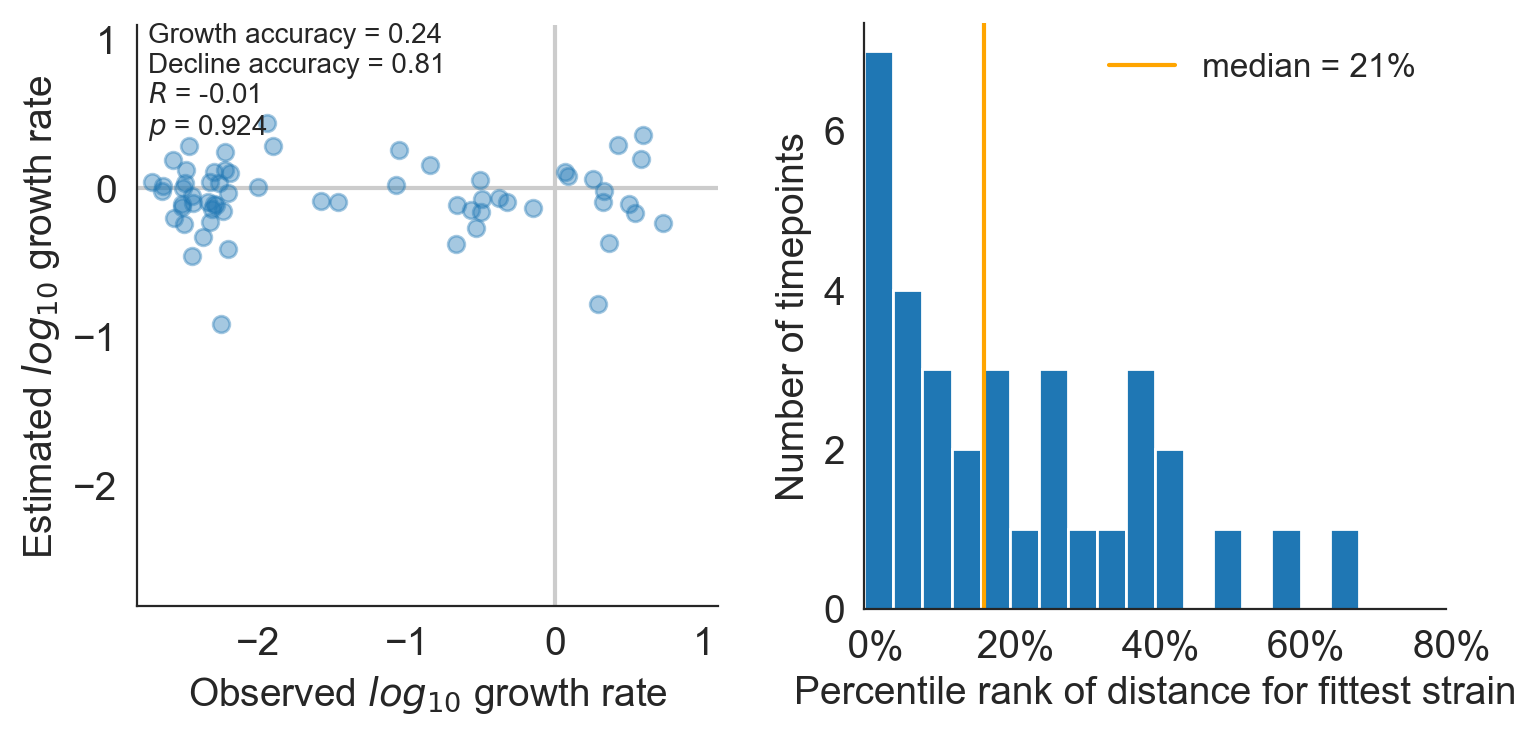

In [313]:
fig = plt.figure(figsize=(8, 4), facecolor='w')
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)

#
# Clade growth rate correlations
#

clade_ax = fig.add_subplot(gs[0])
clade_ax.plot(
    large_clades["log_observed_growth_rate"],
    large_clades["log_estimated_growth_rate"],
    "o",
    alpha=0.4
)

clade_ax.axhline(color="#cccccc", zorder=-5)
clade_ax.axvline(color="#cccccc", zorder=-5)

if p < 0.001:
    p_value = "$p$ < 0.001"
else:
    p_value = "$p$ = %.3f" % p

clade_ax.text(
    0.02,
    0.9,
    "Growth accuracy = %.2f\nDecline accuracy = %.2f\n$R$ = %.2f\n%s" % (growth_accuracy, decline_accuracy, r, p_value),
    fontsize=10,
    horizontalalignment="left",
    verticalalignment="center",
    transform=clade_ax.transAxes
)

clade_ax.set_xlabel("Observed $log_{10}$ growth rate")
clade_ax.set_ylabel("Estimated $log_{10}$ growth rate")

ticks = np.arange(-6, 4, 1)
clade_ax.set_xticks(ticks)
clade_ax.set_yticks(ticks)

clade_ax.set_xlim(log_lower_limit, log_upper_limit)
clade_ax.set_ylim(log_lower_limit, log_upper_limit)
clade_ax.set_aspect("equal")

#
# Estimated closest strain to the future ranking
#

rank_ax = fig.add_subplot(gs[1])

median_best_rank = best_fitness_rank_by_timepoint_df["timepoint_rank"].median()

rank_ax.hist(best_fitness_rank_by_timepoint_df["timepoint_rank"], bins=np.arange(0, 1.01, 0.05), label=None)
rank_ax.axvline(
    median_best_rank,
    color="orange",
    label="median = %i%%" % round(median_best_rank * 100, 0)
)
rank_ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
rank_ax.set_xlim(0, 1)

rank_ax.legend(
    frameon=False
)
rank_ax.set_xlabel("Percentile rank of distance for fittest strain")
rank_ax.set_ylabel("Number of timepoints")

gs.tight_layout(fig)

plt.savefig("../manuscript/figures/validation-of-best-model-for-simulated-populations.png")